# admissionDrug

The following columns are available:

* admissiondrugid - primary key, has no meaning but identifies rows uniquely
* drugOffset - number of minutes from unit admit time that the admission drug was administered
* drugEnteredOffset - number of minutes from unit admit time that the admission drug was entered
* drugNoteType - unique note picklist types e.g.: Comprehensive Progress Admission Intubation
* specialtyType - physician specialty picklist types e.g.: anesthesiology gastroenterology oncology
* userType - who documented the drug from eCareManager user picklist types e.g.: eICU Physician, Nurse, Attending Physician
* rxincluded - Does the Note have associated Rx data: True or False
* writtenIneICU - Was the Note written in the eICU: True or False
* drugName - name of the selected admission drug e.g.: POTASSIUM CHLORIDE/D5NS METAXALONE PRAVACHOL
* drugDosage - dosage of the admission drug e.g.: 20.0000 400.000
* drugUnit - picklist units of the admission drug e.g.: mg mg/kg patch
* drugAdmitFrequency - picklist frequency with which the admission drug is administred e.g.: PRN twice a day at bedtime
* drughiclseqno - a code representing the drug (hierarchical ingredient code list, HICL)

We recommend configuring the `config.ini` file to allow for connection to the database without specifying your password each time.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass

# for configuring connection 
from configobj import ConfigObj
import os

%matplotlib inline

/home/alistairewj/.local/lib/python3.5/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
# Create a database connection using settings from config file
config='../db/config.ini'

# connection info
conn_info = dict()
if os.path.isfile(config):
    config = ConfigObj(config)
    conn_info["sqluser"] = config['username']
    conn_info["sqlpass"] = config['password']
    conn_info["sqlhost"] = config['host']
    conn_info["sqlport"] = config['port']
    conn_info["dbname"] = config['dbname']
    conn_info["schema_name"] = config['schema_name']
else:
    conn_info["sqluser"] = 'postgres'
    conn_info["sqlpass"] = ''
    conn_info["sqlhost"] = 'localhost'
    conn_info["sqlport"] = 5432
    conn_info["dbname"] = 'eicu'
    conn_info["schema_name"] = 'public,eicu_crd'
    
# Connect to the eICU database
print('Database: {}'.format(conn_info['dbname']))
print('Username: {}'.format(conn_info["sqluser"]))
if conn_info["sqlpass"] == '':
    # try connecting without password, i.e. peer or OS authentication
    try:
        if (conn_info["sqlhost"] == 'localhost') & (conn_info["sqlport"]=='5432'):
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   user=conn_info["sqluser"])            
        else:
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   host=conn_info["sqlhost"],
                                   port=conn_info["sqlport"],
                                   user=conn_info["sqluser"])
    except:
        conn_info["sqlpass"] = getpass.getpass('Password: ')

        con = psycopg2.connect(dbname=conn_info["dbname"],
                               host=conn_info["sqlhost"],
                               port=conn_info["sqlport"],
                               user=conn_info["sqluser"],
                               password=conn_info["sqlpass"])
query_schema = 'set search_path to ' + conn_info['schema_name'] + ';'

Database: eicu
Username: alistairewj


## Examine a single patient

In [3]:
patientunitstayid = 2704494

In [4]:
query = query_schema + """
select *
from admissiondrug
where patientunitstayid = {}
order by drugoffset
""".format(patientunitstayid)

df = pd.read_sql_query(query, con)
df.head()

,admissiondrugid,patientunitstayid,drugyear,drugtime24,drugtime,drugoffset,drugenteredyear,drugenteredtime24,drugenteredtime,drugenteredoffset,drugnotetype,specialtytype,usertype,rxincluded,writtenineicu,drugname,drugdosage,drugunit,drugadmitfrequency,drughiclseqno
0,13383114,2704494,2014,16:13:00,evening,-87132,2014,16:18:46,evening,2153,Comprehensive Progress,eCM Primary,THC Physician,True,False,IMDUR,0.0,,,6341
1,13383119,2704494,2014,16:13:00,evening,-87132,2014,16:18:46,evening,2153,Comprehensive Progress,eCM Primary,THC Physician,True,False,ZAROXOLYN,0.0,,,3663
2,13383112,2704494,2014,16:13:00,evening,-87132,2014,16:18:46,evening,2153,Comprehensive Progress,eCM Primary,THC Physician,True,False,EXEMESTANE,0.0,,,20803
3,13383111,2704494,2014,16:13:00,evening,-87132,2014,16:18:46,evening,2153,Comprehensive Progress,eCM Primary,THC Physician,True,False,COREG,0.0,,,13795
4,13383116,2704494,2014,16:13:00,evening,-87132,2014,16:18:46,evening,2153,Comprehensive Progress,eCM Primary,THC Physician,True,False,PROTONIX,0.0,,,22008


In [5]:
# Look at a subset of columns
cols = ['admissiondrugid','patientunitstayid','drugoffset','drugenteredoffset','drugname','drughiclseqno']
df[cols].head()

,admissiondrugid,patientunitstayid,drugoffset,drugenteredoffset,drugname,drughiclseqno
0,13383114,2704494,-87132,2153,IMDUR,6341
1,13383119,2704494,-87132,2153,ZAROXOLYN,3663
2,13383112,2704494,-87132,2153,EXEMESTANE,20803
3,13383111,2704494,-87132,2153,COREG,13795
4,13383116,2704494,-87132,2153,PROTONIX,22008


Here we can see that these drugs were documented 2153 minutes (1.5 days) after ICU admission, but administered 87132 minutes (60 days) *before* ICU admission (thus, the negative offset). Since it's reasonable to assume the patient is still taking the drug (as this is the admissiondrug table), `drugoffset` can likely be treated as a start time for a prescription of the drug.

## Identifying patients admitted on a single drug

Let's look for patients who were admitted on Zaroxolyn.

In [6]:
drug = 'ZAROXOLYN'
query = query_schema + """
select 
  admissiondrugid, patientunitstayid
  , drugoffset, drugenteredoffset
  , drugname, drughiclseqno
from admissiondrug
where drugname = '{}'
""".format(drug)

df_drug = pd.read_sql_query(query, con)
df_drug.set_index('admissiondrugid',inplace=True)
print('{} unit stays with {}.'.format(df_drug['patientunitstayid'].nunique(), drug))

227 unit stays with ZAROXOLYN.


Instead of using the drug name, we could try to use the HICL code.

In [7]:
hicl = 3663
query = query_schema + """
select 
  admissiondrugid, patientunitstayid
  , drugoffset, drugenteredoffset
  , drugname, drughiclseqno
from admissiondrug
where drughiclseqno = {}
""".format(hicl)

df_hicl = pd.read_sql_query(query, con)
df_hicl.set_index('admissiondrugid',inplace=True)

print('{} unit stays with HICL = {}.'.format(df_hicl['patientunitstayid'].nunique(), hicl))

533 unit stays with HICL = 3663.


As we can see, using the HICL returned many more observations. Let's take a look at a few:

In [8]:
# rows in HICL which are *not* in the drug dataframe
idx = ~df_hicl.index.isin(df_drug.index)
# count the drug names
df_hicl.loc[idx, 'drugname'].value_counts()

METOLAZONE    767
Name: drugname, dtype: int64

All the rows use the drug name "Metolazone". Metolazone is the generic name for the brand Zaroxolyn. This demonstrates the utility of using HICL codes to identify drugs - synonyms like these are very common and can be tedious to find.

## Hospitals with data available

In [9]:
query = query_schema + """
select 
  pt.hospitalid
  , count(pt.patientunitstayid) as number_of_patients
  , count(ad.patientunitstayid) as number_of_patients_with_admdrug
from patient pt
left join admissiondrug ad
  on pt.patientunitstayid = ad.patientunitstayid
group by pt.hospitalid
""".format(patientunitstayid)

df = pd.read_sql_query(query, con)
df['data completion'] = df['number_of_patients_with_admdrug'] / df['number_of_patients'] * 100.0
df.sort_values('number_of_patients_with_admdrug', ascending=False, inplace=True)
df.head(n=10)

,hospitalid,number_of_patients,number_of_patients_with_admdrug,data completion
165,420,342170,341168,99.707163
127,142,33887,33003,97.391330
90,382,29047,28871,99.394085
84,365,25941,25735,99.205890
94,281,25564,25092,98.153654
16,391,22992,22840,99.338900
180,394,23574,22485,95.380504
139,440,23644,22343,94.497547
187,283,20045,19724,98.398603
166,443,20072,18666,92.995217


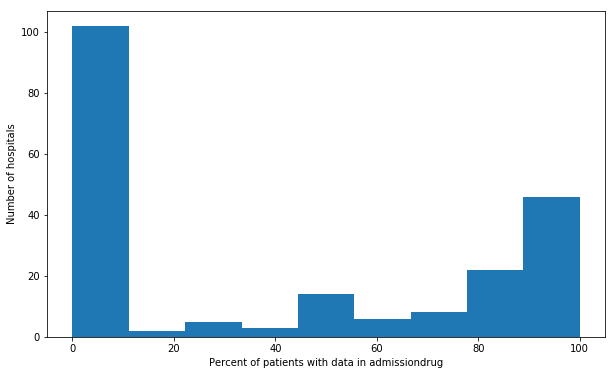

In [11]:
plt.figure(figsize=[10,6])
plt.hist(df['data completion'], bins=np.linspace(0, 100, 10))
plt.xlabel('Percent of patients with data in admissiondrug')
plt.ylabel('Number of hospitals')
plt.show()

As is common in eICU-CRD, there are a subset of hospitals who routinely utilize this portion of the medical record (and thus have 90-100% data completion), while there are other hospitals who rarely use this interface and thus have poor data completion (0-10%).